In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


Total files: 480

Emotion Distribution:
 Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64


<ipython-input-11-f1935915d19b>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Emotions'].value_counts().index, y=df['Emotions'].value_counts().values, palette="viridis")


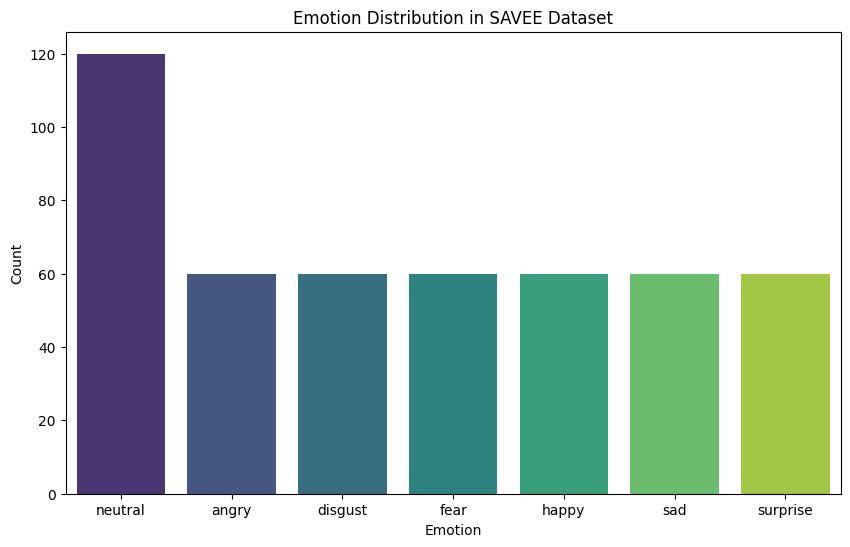

In [ ]:
SAVEE_PATH = "/content/drive/MyDrive/ALL"

def create_savee_df(data_path):
    file_emotion = []
    file_path = []
    for filename in os.listdir(data_path):
        if filename.endswith(".wav"):
            file_path.append(os.path.join(data_path, filename))
            part = filename.split('_')[1]
            ele = part[:-6]
            if ele == 'a': file_emotion.append('angry')
            elif ele == 'd': file_emotion.append('disgust')
            elif ele == 'f': file_emotion.append('fear')
            elif ele == 'h': file_emotion.append('happy')
            elif ele == 'n': file_emotion.append('neutral')
            elif ele == 'sa': file_emotion.append('sad')
            else: file_emotion.append('surprise')
    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

df = create_savee_df(SAVEE_PATH)
print(f"Total files: {len(df)}")
print("\nEmotion Distribution:\n", df['Emotions'].value_counts())

# Plot emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Emotions'].value_counts().index, y=df['Emotions'].value_counts().values, palette="viridis")
plt.title("Emotion Distribution in SAVEE Dataset")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.show()


In [ ]:
def extract_features(audio, sr=None):
    if isinstance(audio, str):
        audio, sr = librosa.load(audio, duration=2.5, offset=0.5)
    elif sr is None:
        raise ValueError("Sample rate must be provided.")

    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=audio))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)

    return np.hstack([mfcc, rms, chroma, spectral_contrast])

# Feature Extraction
X = []
y = []

for index, row in df.iterrows():
    features = extract_features(row['Path'])
    X.append(features)
    y.append(row['Emotions'])

X = np.array(X)
y = np.array(y)

# Standardize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
X, y = [], []
for emotion, path in zip(df['Emotions'], df['Path']):
    for variant in augment_audio(path):
        features = extract_features(variant)
        X.append(features)
        y.append(emotion)

X = np.array(X, dtype=np.float32)
y = np.array(y)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")



Train: 1008, Validation: 216, Test: 216


In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [ ]:
# Step 6: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2019 - loss: 2.4795 - val_accuracy: 0.2870 - val_loss: 2.0396
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3278 - loss: 1.8073 - val_accuracy: 0.4028 - val_loss: 1.5471
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3417 - loss: 1.7432 - val_accuracy: 0.3796 - val_loss: 1.3542
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3618 - loss: 1.6365 - val_accuracy: 0.4167 - val_loss: 1.2983
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3994 - loss: 1.5206 - val_accuracy: 0.4306 - val_loss: 1.2216
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3969 - loss: 1.5083 - val_accuracy: 0.4491 - val_loss: 1.1869
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3615 - loss: 1.5098 - val_accuracy: 0.4954 - val_loss: 1.1438
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3920 - loss: 1.4977 - val_accuracy: 0.4954 - val_loss:

In [ ]:
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

y_pred = np.argmax(model.predict(X_test), axis=1)

print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Training Accuracy: 67.06%
Testing Accuracy: 62.50%


In [ ]:
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)
print("\nClassification Report:")
print(pd.DataFrame(report).T)



Classification Report:
              precision    recall  f1-score  support
angry          0.600000  0.777778  0.677419   27.000
disgust        0.928571  0.481481  0.634146   27.000
fear           0.590909  0.481481  0.530612   27.000
happy          0.866667  0.481481  0.619048   27.000
neutral        0.815789  0.574074  0.673913   54.000
sad            0.462963  0.925926  0.617284   27.000
surprise       0.500000  0.703704  0.584615   27.000
accuracy       0.625000  0.625000  0.625000    0.625
macro avg      0.680700  0.632275  0.619577  216.000
weighted avg   0.697586  0.625000  0.626369  216.000


In [ ]:
performance_df = pd.DataFrame(report).T
best_emotion = performance_df.loc[performance_df['f1-score'].idxmax()]
print("\nBest Performing Emotion:")
print(best_emotion)



Best Performing Emotion:
precision     0.600000
recall        0.777778
f1-score      0.677419
support      27.000000
Name: angry, dtype: float64


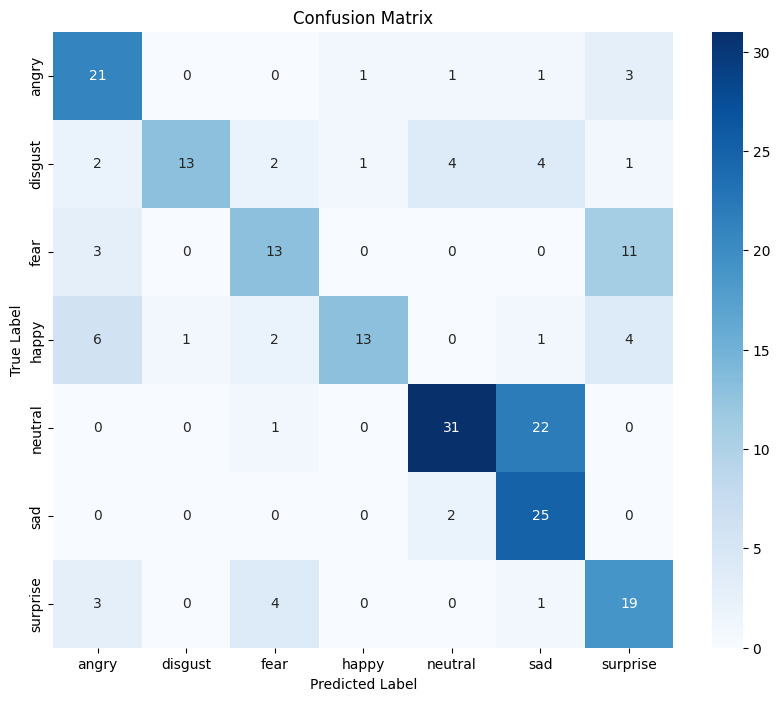

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
model.save("emotion_model.h5")